In [20]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pyomo.environ as pyo # Correct the import here
from pyomo.environ import ConcreteModel,Set,RangeSet,Param,Suffix,Reals,NonNegativeReals,NonPositiveReals,Binary,Objective,minimize,maximize,value
from pyomo.opt import SolverFactory
from pyomo.core import Var, Objective, Constraint
from pyomo.environ import ConstraintList
import time

In [21]:
#Read battery specification 
parametersinput = pd.read_csv('./battery_data.csv', index_col=0)
parameters = parametersinput.loc[1]

#Battery Specification [Constants]
capacity=parameters['Battery_Capacity']
charging_power_limit=parameters["Battery_Power"]
discharging_power_limit=parameters["Battery_Power"]
charging_efficiency=parameters["Battery_Charge_Efficiency"]
discharging_efficiency=parameters["Battery_Discharge_Efficiency"]

# Read load and PV profile data
testData = pd.read_csv('./profile_input.csv')

# Convert the various timeseries/profiles to numpy arrays
load1 = testData['Base_Load'].values
PV1 = testData['PV'].values
sellPrice = testData['Feed_Price'].values
buyPrice = testData['Load_Price'].values


def array_to_dict(arr):
    if not isinstance(arr, (list, np.ndarray)):
        raise ValueError("Input must be a list or NumPy array")
    
    result_dict = {}
    for idx, value in enumerate(arr):
        result_dict[idx + 1] = value
    
    return result_dict

PV1 = array_to_dict(PV1)
load1 = array_to_dict(load1)
sellPrice = array_to_dict(sellPrice)
buyPrice = array_to_dict(buyPrice)

In [22]:
#Environment
model = pyo.ConcreteModel()

#Sets
model.periods = pyo.Set(initialize=range(1,25,1))   #indexed by "t" for time step

#Parameters
model.loads = pyo.Param(model.periods, initialize=load1)     #load demand
model.sellP = pyo.Param(model.periods,initialize=sellPrice)  #price to charge
model.buyP = pyo.Param(model.periods,initialize=buyPrice)    #price to dicsharge
model.PV = pyo.Param(model.periods,initialize=PV1)           #determinsitic solar power production
model.SOC_0 = pyo.Param(model.periods,initialize=0)   #initial state of charge of battery
model.penalty_cost = pyo.Param(model.periods,initialize=10)  #penalty for not covering load demand (arbitrary, used as slack variable)

#Variables:
model.charge = pyo.Var(model.periods, bounds=(0, charging_power_limit))       #assuming no discharge in first hour
model.disc = pyo.Var(model.periods, bounds=(0, discharging_power_limit))  #assuming full discahrge to meet load in first hour
model.penalty = pyo.Var(model.periods, within=NonNegativeReals)                        #variable                      

#Constraints
def load_rule(model, t):
    return model.PV[t] + model.disc[t]  + model.penalty[t] == model.loads[t] + model.charge[t] 
model.load_constraint = pyo.Constraint(model.periods, rule=load_rule)

def SOC_limit(model, t):
    return (0,capacity)
model.SOC = pyo.Var(model.periods,bounds=SOC_limit)

#def SOC_end(model,t):
#    tolerance = 1  # Adjust the tolerance value as needed (so that volume does not HAVE to be full if we simulate over a small time period)
#    return model.SOC[t, max(model.periods)] >= capacity - tolerance

def state_of_charge(model, t):  
    if t == 1:
        return model.SOC[t] == model.SOC_0[t] + model.charge[t] - model.disc[t]
    else:  
        return model.SOC[t] == model.SOC[t-1] + model.charge[t] - model.disc[t]
model.state_of_charge_constraint = pyo.Constraint(model.periods, rule=state_of_charge)

#Objective function to minimize costs
def objective_rule(model):
    return sum(model.charge[t]*model.buyP[t] + model.penalty[t]*model.buyP[t] for t in model.periods) - sum(model.disc[t]*model.sellP[t] for t in model.periods) 
model.objective = pyo.Objective(rule=objective_rule, sense=pyo.minimize)

#solving
solver = SolverFactory('gurobi')
results = solver.solve(model, tee=True)
#results = opt.solve(model, tee=True)
model.display()
#model.pprint()
#model.Constraint.pprint()
print("Objective Value:", model.objective())

Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-03
Read LP format model from file C:\Users\benny\AppData\Local\Temp\tmpw00e3g7t.pyomo.lp
Reading time = 0.01 seconds
x1: 48 rows, 96 columns, 167 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: AMD Ryzen 5 5600H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 48 rows, 96 columns and 167 nonzeros
Model fingerprint: 0xcceeae36
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e-01, 2e-01]
  Bounds range     [3e+00, 6e+00]
  RHS range        [2e+00, 6e+00]
Presolve removed 25 rows and 49 columns
Presolve time: 0.00s
Presolved: 23 rows, 47 columns, 69 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -8.8288552e+00   3.022855e+02   0.000000e+00      0s
Extra simplex iterations after uncrush: 1
      16    

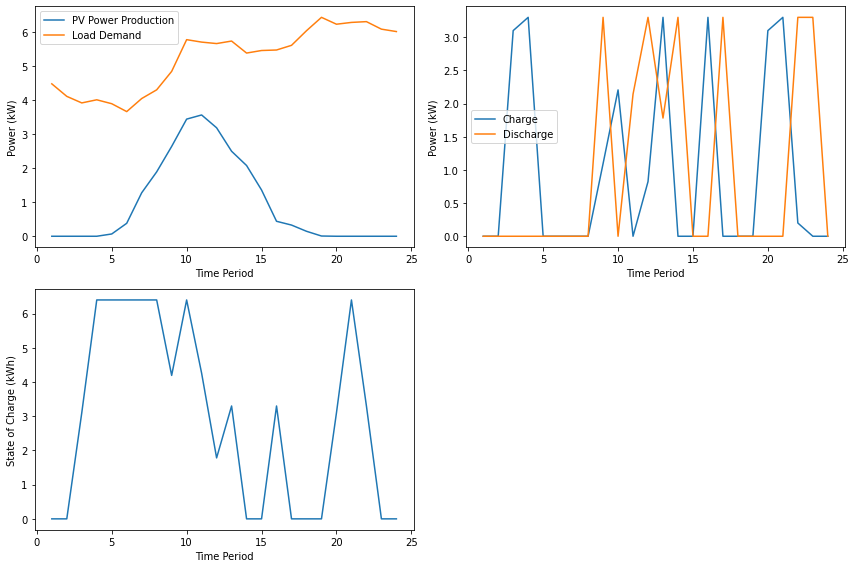

In [23]:
import matplotlib.pyplot as plt

# Extract variable values
PV_values = [pyo.value(model.PV[t]) for t in model.periods]
charge_values = [pyo.value(model.charge[t]) for t in model.periods]
disc_values = [pyo.value(model.disc[t]) for t in model.periods]
load_values = [pyo.value(model.loads[t]) for t in model.periods]
SOC_values = [pyo.value(model.SOC[t]) for t in model.periods]

# Create time periods
time_periods = list(model.periods)

# Create subplots for PV, charge, discharge, load, and SOC
plt.figure(figsize=(12, 8))

# Plot PV power production
plt.subplot(2, 2, 1)
plt.plot(time_periods, PV_values, label='PV Power Production')
plt.plot(time_periods, load_values, label='Load Demand')
plt.xlabel('Time Period')
plt.ylabel('Power (kW)')
plt.legend()

# Plot charge and discharge
plt.subplot(2, 2, 2)
plt.plot(time_periods, charge_values, label='Charge')
plt.plot(time_periods, disc_values, label='Discharge')
plt.xlabel('Time Period')
plt.ylabel('Power (kW)')
plt.legend()

# Plot SOC
plt.subplot(2, 2, 3)
plt.plot(time_periods, SOC_values, label='SOC')
plt.xlabel('Time Period')
plt.ylabel('State of Charge (kWh)')

plt.tight_layout()
plt.show()


[0.0, 0.0, 3.1000000000000005, 3.3, 0.0, 0.0, 0.0, 0.0, 1.0939999999999994, 2.2060000000000004, 0.0, 0.8239999999999998, 3.3, 0.0, 0.0, 3.3, 0.0, 0.0, 0.0, 3.1000000000000005, 3.3, 0.1999999999999993, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.3, 0.0, 2.1420000000000003, 3.3, 1.782, 3.3, 0.0, 0.0, 3.3, 0.0, 0.0, 0.0, 0.0, 3.3, 3.3, 0.0]


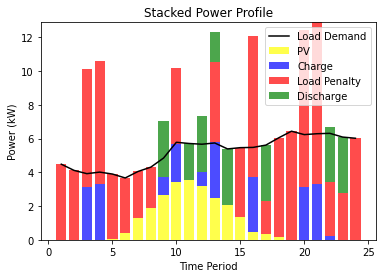

In [24]:
import matplotlib.pyplot as plt
import numpy as np

# Extract values from the Pyomo model
charge_values = [model.charge[t]() for t in model.periods]
pv_values = [model.PV[t] for t in model.periods]
load_penalty_values = [model.penalty[t]() for t in model.periods]
load_demand_values = [model.loads[t] for t in model.periods]
print(charge_values)


# Calculate discharge values as the difference between load penalty and load demand
discharge_values = [model.disc[t]() for t in model.periods]
print(discharge_values)
# Create an array for the time periods
time_periods = list(model.periods)

# Create a stacked bar chart
fig, ax = plt.subplots()

# Plot the PV power
ax.bar(time_periods, pv_values, label='PV', alpha=0.7, color='yellow')

# Plot the charge power
ax.bar(time_periods, charge_values, bottom=pv_values, label='Charge', alpha=0.7, color='blue')

# Plot the load penalty
ax.bar(time_periods, load_penalty_values, bottom=np.array(pv_values) + np.array(charge_values), label='Load Penalty', alpha=0.7, color='red')

# Plot the discharge power
ax.bar(time_periods, discharge_values, bottom=np.array(pv_values) + np.array(charge_values) + np.array(load_penalty_values), label='Discharge', alpha=0.7, color='green')

# Plot the load demand as a curve
ax.plot(time_periods, load_demand_values, label='Load Demand', color='black')

# Set labels and legend
ax.set_xlabel('Time Period')
ax.set_ylabel('Power (kW)')
ax.set_title('Stacked Power Profile')
ax.legend()

# Show the plot
plt.show()


In [25]:
def charging_power_limit_rule(model, t):
    return (0,charging_power_limit)
model.charging_power_limit_constraint = pyo.Constraint(model.periods, rule=charging_power_limit_rule)
model.charge = pyo.Var(model.periods, bounds=charging_power_limit_rule)  #, initialize=initial_charge_values)


def discharging_power_limit_rule(model, t):
    return (0,discharging_power_limit)
model.discharging_power_limit_constraint = pyo.Constraint(model.periods, rule=discharging_power_limit_rule)
model.disc = pyo.Var(model.periods, bounds=discharging_power_limit_rule)    #, initialize=initial_discharge_values)


'pyomo.core.base.var.IndexedVar'>) on block unknown with a new Component
(type=<class 'pyomo.core.base.var.IndexedVar'>). This is usually indicative of
a modelling error. To avoid this warning, use block.del_component() and
block.add_component().
'pyomo.core.base.var.IndexedVar'>) on block unknown with a new Component
(type=<class 'pyomo.core.base.var.IndexedVar'>). This is usually indicative of
a modelling error. To avoid this warning, use block.del_component() and
block.add_component().
